# Importing Required packages

In [1]:
!pip install patchify --quiet
!pip install opendatasets --quiet
!pip install segmentation_models --quiet
!pip install wandb --quiet
!pip install keract

In [2]:
import wandb

wandb.login(key='0df3ee3be92488b9af0d7d8c06b9bd84062babf9')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import opendatasets as od
from PIL import Image
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# od.download('https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery')

In [5]:
from keras import backend as K

## Copying path to collect images and initializing constants, variables

In [6]:
project_path = '/kaggle/input/semantic-segmentation-of-aerial-imagery'
dataset_name = 'Semantic segmentation dataset'
patch_size = 256
min_max_scaler = MinMaxScaler()
image_dataset = []
mask_dataset = []

#### Saving images into image_dataset and mask_dataset

In [7]:
for image_type in ['images', 'masks']:
    if image_type == 'images':
        image_extension = 'jpg'
    elif image_type == 'masks':
        image_extension = 'png'

    for tile_id in range(1,9):
        for image_id in range(1,10):
            image_path = f'{project_path}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}'
            image = cv2.imread(image_path)

            if image is not None:
                if image_type == 'masks':
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                size_x = (image.shape[0] // patch_size) * patch_size
                size_y = (image.shape[1] // patch_size) * patch_size

                image = Image.fromarray(image)
                image = image.crop((0 , 0 , size_x, size_y))

                image = np.array(image)

                patched_images = patchify(image, (patch_size, patch_size, 3), step = patch_size)

                for i in range(patched_images.shape[0]):
                    for j in range(patched_images.shape[1]):
                        individual_patched_image = patched_images[i,j,:,:]

                        if image_type == 'images':
                            image = individual_patched_image
                            pixels = image.reshape(-1, image.shape[-1])
                            pixels = min_max_scaler.fit_transform(pixels)
                            image = pixels.reshape(image.shape)

                            individual_patched_image = image[0]
                            image_dataset.append(individual_patched_image)
                        elif image_type == 'masks':
                            individual_patched_mask = individual_patched_image[0]
                            mask_dataset.append(individual_patched_mask)


In [8]:
print(len(image_dataset), len(mask_dataset))

1305 1305


## Data Preprocessing

In [9]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
print(image_dataset.shape, mask_dataset.shape)

(1305, 256, 256, 3) (1305, 256, 256, 3)


280


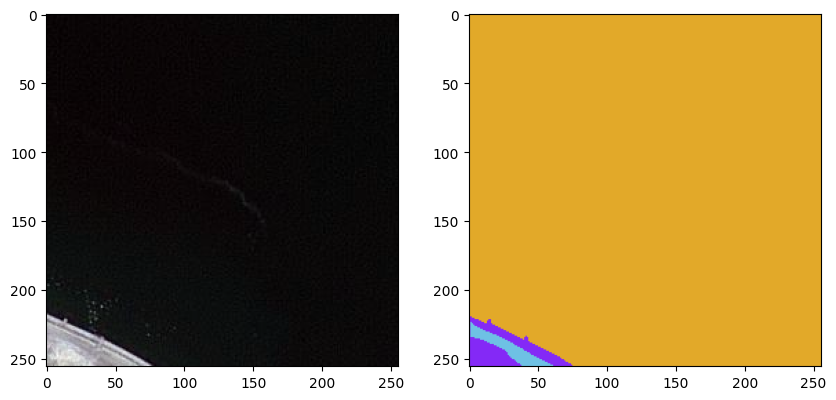

In [10]:
random_int = random.randint(0, len(image_dataset))
print(random_int)
plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(image_dataset[random_int])
plt.subplot(122)
plt.imshow(mask_dataset[random_int])

In [11]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#50E3C2'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[ 80 227 194]
[155 155 155]


In [12]:
def rgb_to_label(label):
    label_segment = np.zeros(label.shape, dtype=np.uint8)
    label_segment[np.all(label == class_water, axis=-1)] = 0
    label_segment[np.all(label == class_land, axis = -1)] = 1
    label_segment[np.all(label == class_road, axis = -1)] = 2
    label_segment[np.all(label == class_building, axis = -1)] = 3
    label_segment[np.all(label == class_vegetation, axis = -1)] = 4
    label_segment[np.all(label == class_unlabeled, axis = -1)] = 5
    label_segment = label_segment[:, :, 0]
    return label_segment

In [13]:
labels = []

In [14]:
for i in range(mask_dataset.shape[0]):
    label = rgb_to_label(mask_dataset[i])
    labels.append(label)

In [15]:
labels = np.expand_dims(np.array(labels),axis=3)

In [16]:
labels.shape

(1305, 256, 256, 1)

In [17]:
print(f'Total Unique values based on mask: {np.unique(labels)}')

Total Unique values based on mask: [0 1 2 3 4 5]


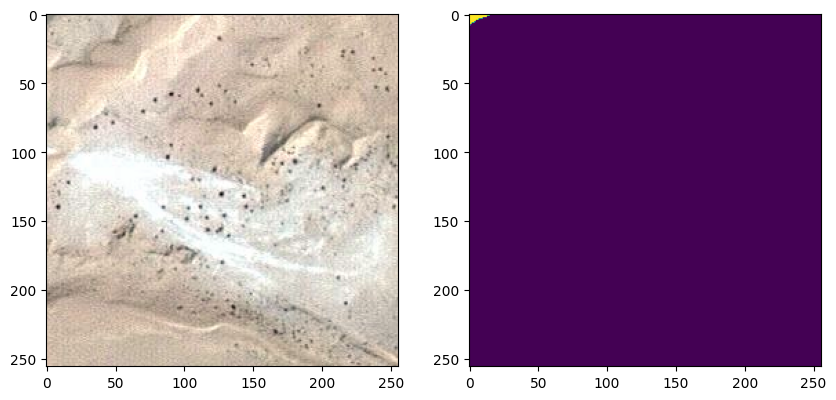

In [18]:
random_int = random.randint(0, len(image_dataset))
plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(image_dataset[random_int])
plt.subplot(122)
plt.imshow(labels[random_int])

In [19]:
label_categorical_dataset = to_categorical(labels, len(np.unique(labels)))
master_dataset = image_dataset

In [20]:
x_train, x_test, y_train, y_test = train_test_split(master_dataset, label_categorical_dataset, test_size=0.2, random_state=42)

In [21]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1044, 256, 256, 3) (261, 256, 256, 3) (1044, 256, 256, 6) (261, 256, 256, 6)


In [22]:
image_height = x_train.shape[1]
image_width = x_train.shape[2]
image_channels = x_train.shape[3]
total_classes = y_train.shape[3]

## Model Building - Unet

In [23]:
def jaccard_coef(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value

#### Model

In [24]:
def multi_unet_model(n_classes = 5, image_height = 256, image_width = 256, image_channels = 1):
    inputs = Input((image_height, image_width, image_channels))

    source_input = inputs
    c1 = Conv2D(16, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(source_input)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(p2)
    c3= Dropout(0.2)(c3)
    c3 = Conv2D(64, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(p3)
    c4= Dropout(0.2)(c4)
    c4 = Conv2D(128, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(c5)

    u6 = Conv2DTranspose(128, (2,2), strides= (2,2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2,2), strides= (2,2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2,2), strides= (2,2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(c8)

    u9 = Conv2DTranspose(16, (2,2), strides= (2,2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis = 3)
    c9 = Conv2D(16, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(c9)


    outputs = Conv2D(n_classes, kernel_size=(1,1), activation='softmax')(c9)
    model = Model(inputs = [inputs], outputs = [outputs])
    return model


In [25]:
metrics = ["accuracy", jaccard_coef]

In [26]:
def get_deep_learning_model():
    return multi_unet_model(n_classes= total_classes,
                            image_height= image_height,
                            image_width= image_width,
                            image_channels = image_channels)

In [27]:
model = get_deep_learning_model()

In [28]:
model.get_config()

{'name': 'model',
 'trainable': True,
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv2d',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'Dropout',
   

## Generating loss function

In [29]:
weights = [0.166, 0.166, 0.166, 0.166, 0.166, 0.166]

In [30]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [31]:
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()

total_loss = dice_loss + (1 * focal_loss)

### Model Compilation

In [32]:
model.compile(optimizer='adam', loss=total_loss, metrics = metrics)

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [34]:
from keras.utils.vis_utils import plot_model

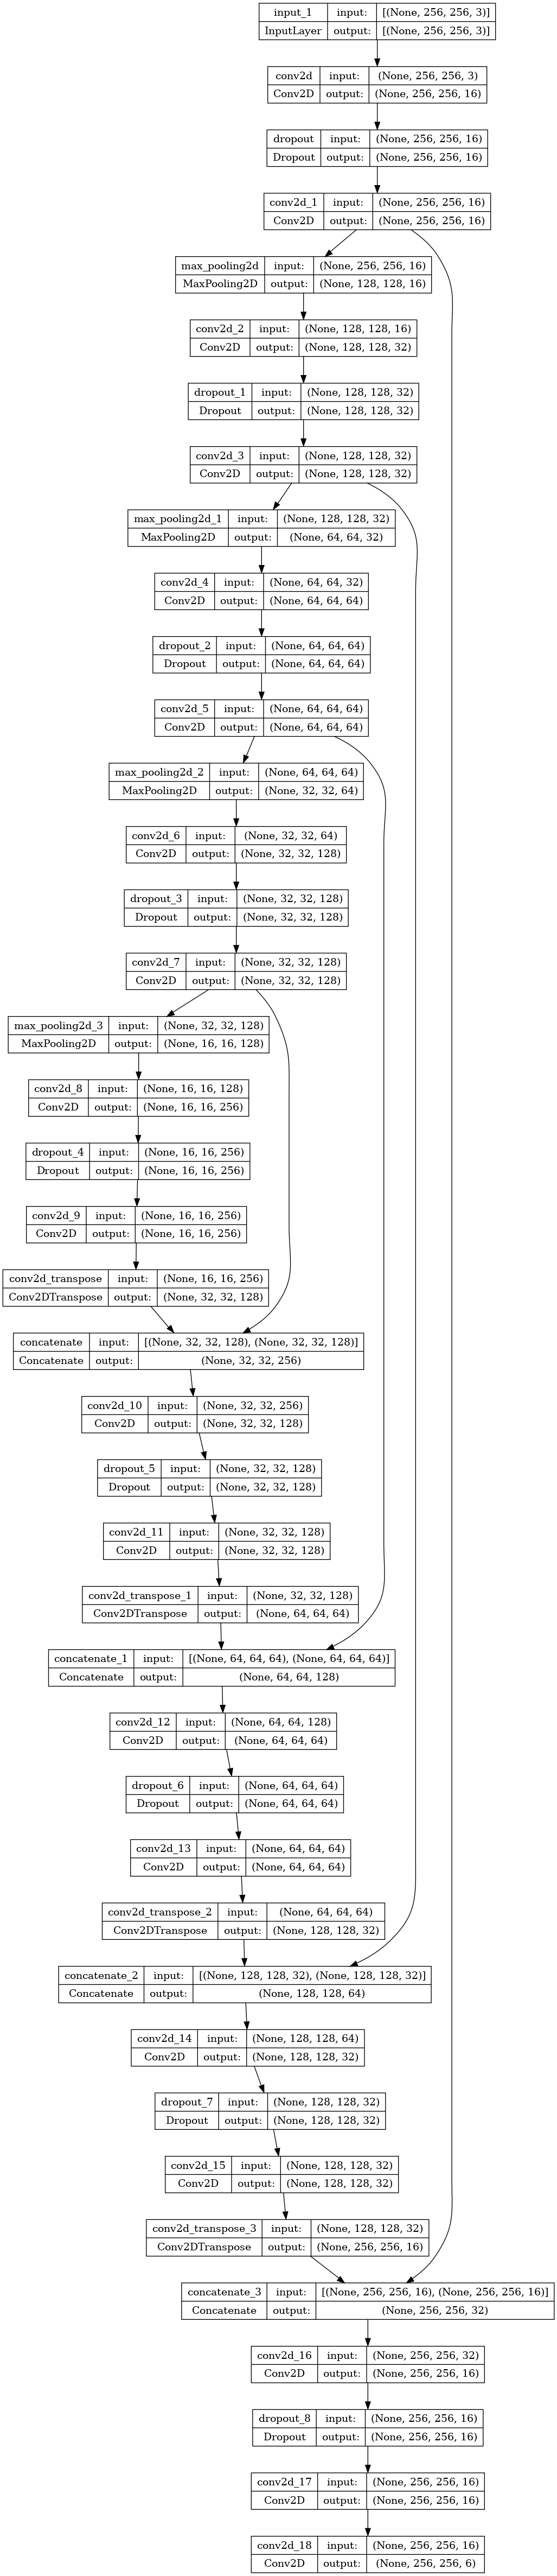

In [35]:
plot_model(model, to_file='satellite_model_plot.png', show_shapes=True, show_layer_names=True)

In [36]:
import keras
from IPython.display import display, clear_output
%matplotlib inline

In [37]:
class PlotMetrics(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epochs = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
        self.jaccard_coef = []
        self.val_jaccard_coef = []

        self.fig, self.axes = plt.subplots(1, 3, figsize=(20, 4))
        plt.ion()

    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch + 1)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))
        self.jaccard_coef.append(logs.get('jaccard_coef'))
        self.val_jaccard_coef.append(logs.get('val_jaccard_coef'))

        for ax in self.axes:
            ax.clear()

        self.axes[0].plot(self.epochs, self.losses, label='loss')
        self.axes[0].plot(self.epochs, self.val_losses, label='val_loss')
        self.axes[0].legend()
        self.axes[0].set_title('Loss')

        self.axes[1].plot(self.epochs, self.accuracy, label='accuracy')
        self.axes[1].plot(self.epochs, self.val_accuracy, label='val_accuracy')
        self.axes[1].legend()
        self.axes[1].set_title('Accuracy')

        self.axes[2].plot(self.epochs, self.jaccard_coef, label='jaccard_coef')
        self.axes[2].plot(self.epochs, self.val_jaccard_coef, label='val_jaccard_coef')
        self.axes[2].legend()
        self.axes[2].set_title('IoU')

        display(self.fig)
        clear_output(wait=True)

plot_loss = PlotMetrics()

In [38]:
import wandb
from wandb.keras import WandbCallback

In [39]:
wandb.init(project='satellite-segmentation-imagery', entity='ramanujachanduri')

wandb: Currently logged in as: ramanujachanduri. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231121_090908-26tferzz
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run celestial-armadillo-3
wandb: ⭐️ View project at https://wandb.ai/ramanujachanduri/satellite-segmentation-imagery
wandb: 🚀 View run at https://wandb.ai/ramanujachanduri/satellite-segmentation-imagery/runs/26tferzz


In [40]:
wandb.log({'accuracy': jaccard_coef, 'loss': total_loss})

In [41]:
wandb.config.dropout = 0.2

In [42]:
model_history = model.fit(x_train, y_train, batch_size=16,
                          verbose=1, epochs=10,
                          validation_data=(x_test, y_test),
                          # callbacks=[plot_loss],
                          callbacks = [WandbCallback()],
                          shuffle=False)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10


2023-11-21 09:10:13.927167: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/66 [==============================] - ETA: 0s - loss: 0.9958 - accuracy: 0.5491 - jaccard_coef: 0.2599

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_090908-26tferzz/files/model-best)... Done. 0.1s


66/66 [==============================] - 45s 374ms/step - loss: 0.9958 - accuracy: 0.5491 - jaccard_coef: 0.2599 - val_loss: 0.9731 - val_accuracy: 0.6718 - val_jaccard_coef: 0.3277
Epoch 2/10
66/66 [==============================] - ETA: 0s - loss: 0.9641 - accuracy: 0.7018 - jaccard_coef: 0.4311

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_090908-26tferzz/files/model-best)... Done. 0.1s


66/66 [==============================] - 18s 280ms/step - loss: 0.9641 - accuracy: 0.7018 - jaccard_coef: 0.4311 - val_loss: 0.9561 - val_accuracy: 0.7418 - val_jaccard_coef: 0.5194
Epoch 3/10
66/66 [==============================] - ETA: 0s - loss: 0.9519 - accuracy: 0.7470 - jaccard_coef: 0.5082

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_090908-26tferzz/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 289ms/step - loss: 0.9519 - accuracy: 0.7470 - jaccard_coef: 0.5082 - val_loss: 0.9511 - val_accuracy: 0.7515 - val_jaccard_coef: 0.5088
Epoch 4/10
66/66 [==============================] - ETA: 0s - loss: 0.9469 - accuracy: 0.7606 - jaccard_coef: 0.5318

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_090908-26tferzz/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 290ms/step - loss: 0.9469 - accuracy: 0.7606 - jaccard_coef: 0.5318 - val_loss: 0.9459 - val_accuracy: 0.7626 - val_jaccard_coef: 0.5504
Epoch 5/10
66/66 [==============================] - ETA: 0s - loss: 0.9418 - accuracy: 0.7737 - jaccard_coef: 0.5555

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_090908-26tferzz/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 287ms/step - loss: 0.9418 - accuracy: 0.7737 - jaccard_coef: 0.5555 - val_loss: 0.9437 - val_accuracy: 0.7651 - val_jaccard_coef: 0.5642
Epoch 6/10
66/66 [==============================] - ETA: 0s - loss: 0.9365 - accuracy: 0.7896 - jaccard_coef: 0.5840

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_090908-26tferzz/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 289ms/step - loss: 0.9365 - accuracy: 0.7896 - jaccard_coef: 0.5840 - val_loss: 0.9371 - val_accuracy: 0.7905 - val_jaccard_coef: 0.5981
Epoch 7/10
66/66 [==============================] - ETA: 0s - loss: 0.9322 - accuracy: 0.8026 - jaccard_coef: 0.6062

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_090908-26tferzz/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 288ms/step - loss: 0.9322 - accuracy: 0.8026 - jaccard_coef: 0.6062 - val_loss: 0.9344 - val_accuracy: 0.7986 - val_jaccard_coef: 0.6110
Epoch 8/10
66/66 [==============================] - ETA: 0s - loss: 0.9274 - accuracy: 0.8172 - jaccard_coef: 0.6299

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_090908-26tferzz/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 284ms/step - loss: 0.9274 - accuracy: 0.8172 - jaccard_coef: 0.6299 - val_loss: 0.9323 - val_accuracy: 0.8048 - val_jaccard_coef: 0.6239
Epoch 9/10
66/66 [==============================] - ETA: 0s - loss: 0.9253 - accuracy: 0.8231 - jaccard_coef: 0.6393

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_090908-26tferzz/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 291ms/step - loss: 0.9253 - accuracy: 0.8231 - jaccard_coef: 0.6393 - val_loss: 0.9307 - val_accuracy: 0.8116 - val_jaccard_coef: 0.6376
Epoch 10/10
66/66 [==============================] - ETA: 0s - loss: 0.9231 - accuracy: 0.8297 - jaccard_coef: 0.6498

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_090908-26tferzz/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 287ms/step - loss: 0.9231 - accuracy: 0.8297 - jaccard_coef: 0.6498 - val_loss: 0.9241 - val_accuracy: 0.8257 - val_jaccard_coef: 0.6573


In [43]:
model_history.params

{'verbose': 1, 'epochs': 10, 'steps': 66}

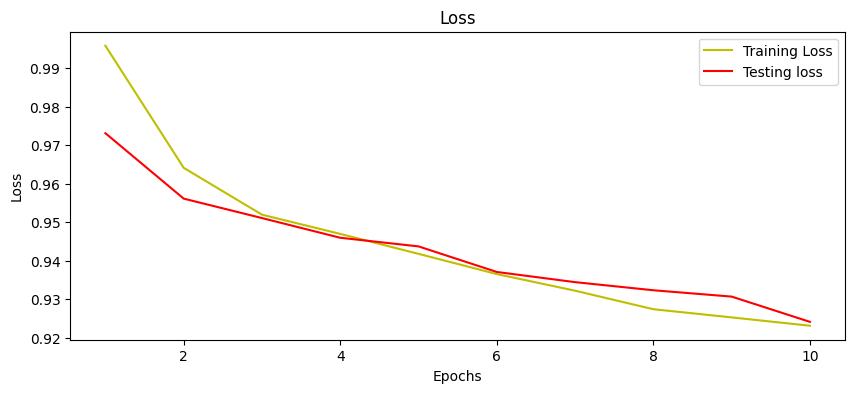

In [44]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1,len(loss) + 1)

plt.figure(figsize=(10,4))

plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Testing loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

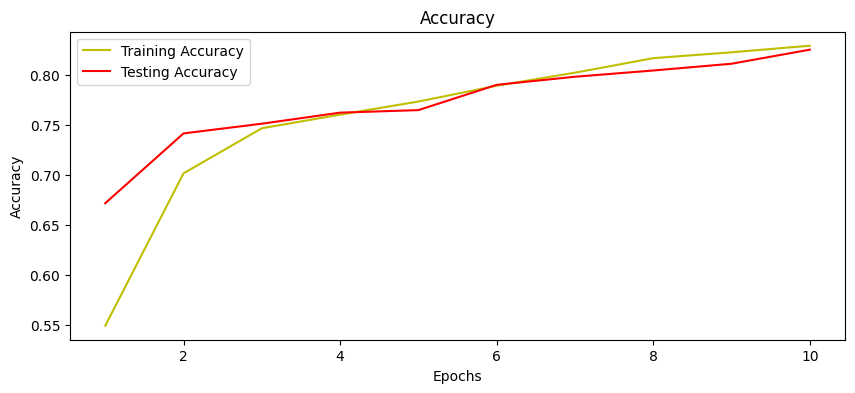

In [45]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
epochs = range(1,len(accuracy) + 1)

plt.figure(figsize=(10,4))

plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Testing Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

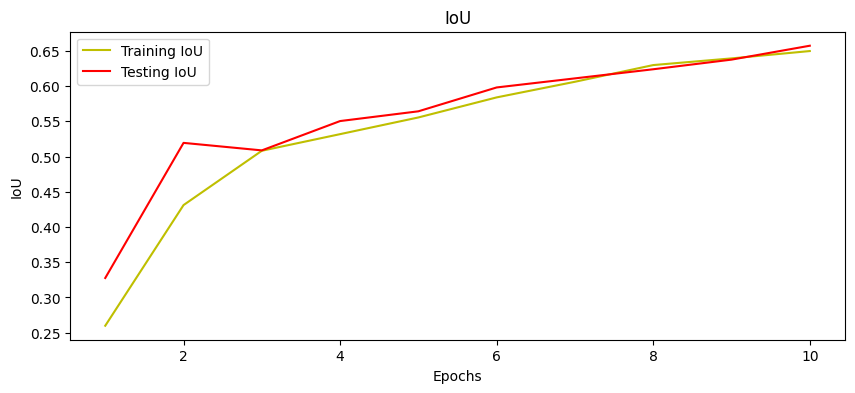

In [46]:
jaccard_coef = model_history.history['jaccard_coef']
val_jaccard_coef = model_history.history['val_jaccard_coef']
epochs = range(1,len(jaccard_coef) + 1)

plt.figure(figsize=(10,4))

plt.plot(epochs, jaccard_coef, 'y', label='Training IoU')
plt.plot(epochs, val_jaccard_coef, 'r', label='Testing IoU')
plt.title('IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

## Model Prediction

In [47]:
# Prediction
y_pred = model.predict(x_test)
y_pred_argmax = np.argmax(y_pred, axis=3)

y_test_argmax = np.argmax(y_pred, axis=3)

9/9 [==============================] - 3s 61ms/step


## Comparing prediction results

251
1/1 [==============================] - 0s 497ms/step


Text(0.5, 1.0, 'Predicted Image')

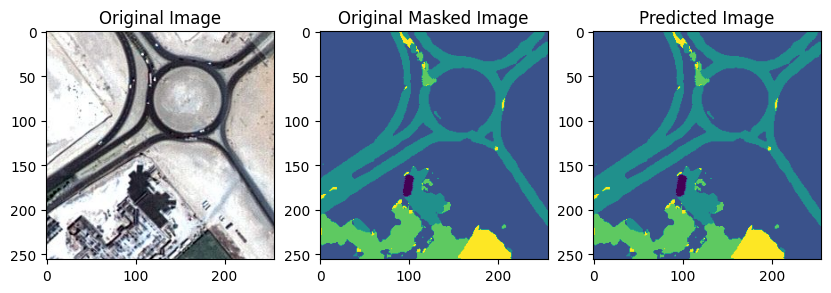

In [48]:
test_image_number = random.randint(0, len(x_test))
print(test_image_number)
test_image = x_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

# prediction = saved_model.predict(test_image_input)
prediction = model.predict(test_image_input)
prediction_image = np.argmax(prediction, axis = 3)
predicted_image = prediction_image[0,:,:]

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(test_image)
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(ground_truth_image)
plt.title('Original Masked Image')
plt.subplot(1,3,3)
plt.imshow(predicted_image)
plt.title('Predicted Image')

In [49]:
model.save('satellite_segmentation_full.h5')

## Model saving and reloading(with custom loss)

In [50]:
# model.get_config()
model.save('satellite_segmentation.h5')

In [51]:
from keras.models import load_model

In [52]:
saved_model = load_model('/kaggle/working/satellite_segmentation.h5', custom_objects=({'dice_loss_plus_1focal_loss': total_loss, 'jaccard_coef': jaccard_coef}))

## Performing custom image prediction from google maps

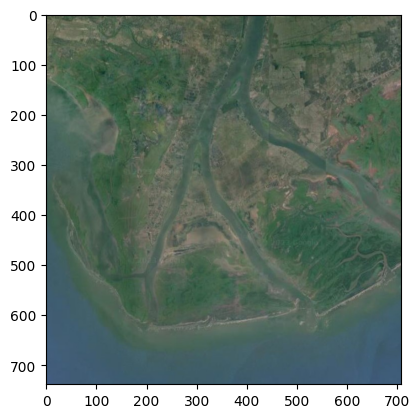

In [53]:
plt.imshow(Image.open('/kaggle/input/satellite-imagery-test-data/image1.jpg'))

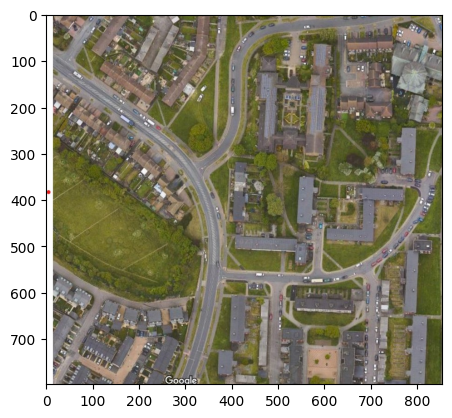

In [54]:
plt.imshow(Image.open('/kaggle/input/satellite-imagery-test-data/image2.jpg'))

In [55]:
image1 = Image.open('/kaggle/input/satellite-imagery-test-data/image1.jpg')
image1 = image1.resize((256, 256))
image1 = np.array(image1)
image1 = np.expand_dims(image1, 0)

In [56]:
image2 = Image.open('/kaggle/input/satellite-imagery-test-data/image2.jpg')
image2 = image2.resize((256, 256))
image2 = np.array(image2)
image2 = np.expand_dims(image2, 0)

In [57]:
prediction = saved_model.predict(image2)

1/1 [==============================] - 0s 256ms/step


In [58]:
predicted_image = np.argmax(prediction, axis = 3)[0,:,:]

Text(0.5, 1.0, 'Predicted Image')

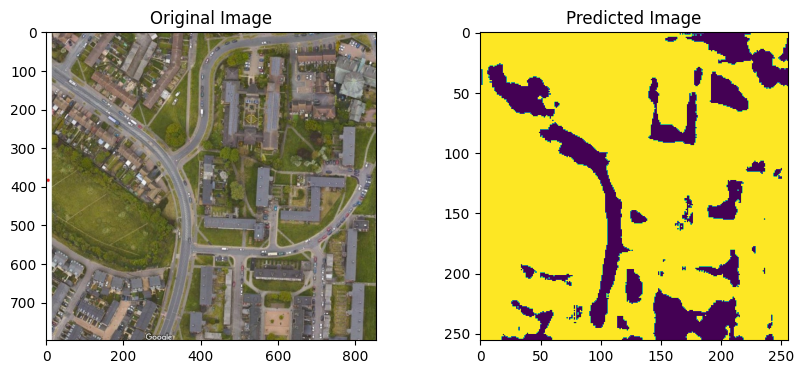

In [59]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(Image.open('/kaggle/input/satellite-imagery-test-data/image2.jpg'))
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(predicted_image)
plt.title('Predicted Image')

In [60]:
import keract as ke

In [61]:
import os

folder_path = '/kaggle/working/activations'
os.makedirs(folder_path, exist_ok=True)

In [62]:
activations = ke.get_activations(saved_model, image1, nodes_to_evaluate=None, output_format='simple', auto_compile=True)

In [63]:
ke.display_activations(activations, cmap='viridis', save=True, directory='/kaggle/working/activations')

input_1 (1, 256, 256, 3) 
conv2d (1, 256, 256, 16) 
dropout (1, 256, 256, 16) 
conv2d_1 (1, 256, 256, 16) 
max_pooling2d (1, 128, 128, 16) 
conv2d_2 (1, 128, 128, 32) 
dropout_1 (1, 128, 128, 32) 
conv2d_3 (1, 128, 128, 32) 
max_pooling2d_1 (1, 64, 64, 32) 
conv2d_4 (1, 64, 64, 64) 
dropout_2 (1, 64, 64, 64) 
conv2d_5 (1, 64, 64, 64) 
max_pooling2d_2 (1, 32, 32, 64) 
conv2d_6 (1, 32, 32, 128) 
dropout_3 (1, 32, 32, 128) 
conv2d_7 (1, 32, 32, 128) 
max_pooling2d_3 (1, 16, 16, 128) 
conv2d_8 (1, 16, 16, 256) 
dropout_4 (1, 16, 16, 256) 
conv2d_9 (1, 16, 16, 256) 
conv2d_transpose (1, 32, 32, 128) 
concatenate (1, 32, 32, 256) 
conv2d_10 (1, 32, 32, 128) 
dropout_5 (1, 32, 32, 128) 
conv2d_11 (1, 32, 32, 128) 
conv2d_transpose_1 (1, 64, 64, 64) 
concatenate_1 (1, 64, 64, 128) 
conv2d_12 (1, 64, 64, 64) 
dropout_6 (1, 64, 64, 64) 
conv2d_13 (1, 64, 64, 64) 
conv2d_transpose_2 (1, 128, 128, 32) 
concatenate_2 (1, 128, 128, 64) 
conv2d_14 (1, 128, 128, 32) 
dropout_7 (1, 128, 128, 32) 
conv2

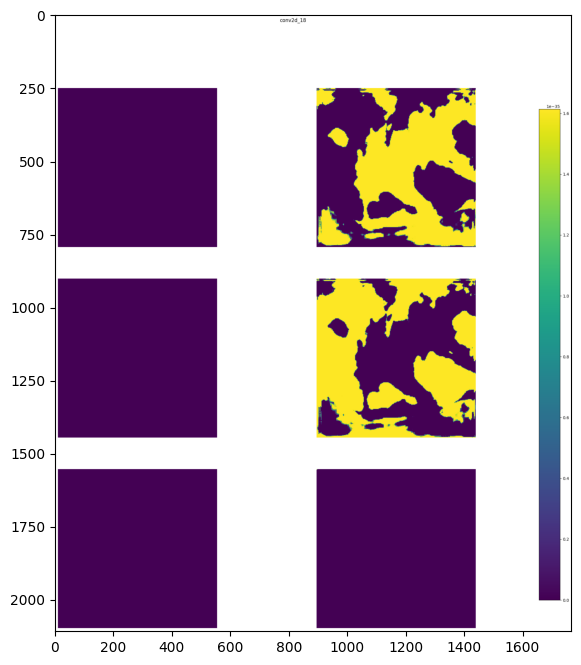

In [64]:
plt.figure(figsize=(8,8))
plt.imshow(Image.open('/kaggle/working/activations/40_conv2d_18.png'))

In [65]:
folder_path = '/kaggle/working/heatmaps'
os.makedirs(folder_path, exist_ok=True)

In [66]:
image1 = Image.open('/kaggle/input/satellite-imagery-test-data/image1.jpg')
image1 = image1.resize((256, 256))
image_as_array = np.array(image1)
image_as_array = image_as_array.astype(np.float32)
ke.display_heatmaps(activations, image_as_array, save=True, directory='/kaggle/working/heatmaps')

input_1 (1, 256, 256, 3) 
conv2d (1, 256, 256, 16) 
dropout (1, 256, 256, 16) 
conv2d_1 (1, 256, 256, 16) 
max_pooling2d (1, 128, 128, 16) 
conv2d_2 (1, 128, 128, 32) 
dropout_1 (1, 128, 128, 32) 
conv2d_3 (1, 128, 128, 32) 
max_pooling2d_1 (1, 64, 64, 32) 
conv2d_4 (1, 64, 64, 64) 
dropout_2 (1, 64, 64, 64) 
conv2d_5 (1, 64, 64, 64) 
max_pooling2d_2 (1, 32, 32, 64) 
conv2d_6 (1, 32, 32, 128) 
dropout_3 (1, 32, 32, 128) 
conv2d_7 (1, 32, 32, 128) 
max_pooling2d_3 (1, 16, 16, 128) 
conv2d_8 (1, 16, 16, 256) 
dropout_4 (1, 16, 16, 256) 
conv2d_9 (1, 16, 16, 256) 
conv2d_transpose (1, 32, 32, 128) 
concatenate (1, 32, 32, 256) 
conv2d_10 (1, 32, 32, 128) 
dropout_5 (1, 32, 32, 128) 
conv2d_11 (1, 32, 32, 128) 
conv2d_transpose_1 (1, 64, 64, 64) 
concatenate_1 (1, 64, 64, 128) 
conv2d_12 (1, 64, 64, 64) 
dropout_6 (1, 64, 64, 64) 
conv2d_13 (1, 64, 64, 64) 
conv2d_transpose_2 (1, 128, 128, 32) 
concatenate_2 (1, 128, 128, 64) 
conv2d_14 (1, 128, 128, 32) 
dropout_7 (1, 128, 128, 32) 
conv2